In [5]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [6]:
import os
from google.colab import drive
drive.mount('/content/drive')
checkpoints = '/content/drive/MyDrive/CSE455/birds/'
if not os.path.exists(checkpoints):
    os.makedirs(checkpoints)

Mounted at /content/drive


In [7]:
import os
if not os.path.exists('birds21wi'):
    !mkdir birds21wi
    os.chdir('birds21wi')
    !wget https://pjreddie.com/media/files/birds/train.tar
    !wget https://pjreddie.com/media/files/birds/test.tar
    !wget https://pjreddie.com/media/files/birds/names.txt
    !tar xf train.tar
    !tar xf test.tar
    !mkdir testing
    !mv test testing
    os.chdir('..')

--2021-06-09 03:46:52--  https://pjreddie.com/media/files/birds/train.tar
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7970048512 (7.4G) [application/octet-stream]
Saving to: ‘train.tar’

train.tar           100%[===================>]   7.42G  9.47MB/s    in 14m 43s 

2021-06-09 04:01:35 (8.61 MB/s) - ‘train.tar’ saved [7970048512/7970048512]

--2021-06-09 04:01:35--  https://pjreddie.com/media/files/birds/test.tar
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2057210880 (1.9G) [application/octet-stream]
Saving to: ‘test.tar’

test.tar            100%[===================>]   1.92G  12.9MB/s    in 2m 42s  

2021-06-09 04:04:18 (12.1 MB/s) - ‘test.tar’ saved [2057210880/2057210880]

--2021-06-09 04:04:18--  https:

In [8]:
def get_bird_data(augmentation=0):
    transform_train = transforms.Compose([
        transforms.Resize([128,128]),
        transforms.RandomCrop(128, padding=8, padding_mode='edge'), # Take 128x128 crops from padded images
        transforms.RandomHorizontalFlip(),    # 50% of time flip image along y-axis
        transforms.ToTensor(),
    ])
    
    transform_test = transforms.Compose([
        transforms.Resize(128),
        transforms.ToTensor(),
    ])
    trainset = torchvision.datasets.ImageFolder(root='birds21wi/train', transform=transform_train)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

    testset = torchvision.datasets.ImageFolder(root='birds21wi/testing', transform=transform_test)
    testloader = torch.utils.data.DataLoader(testset, batch_size=2, shuffle=False, num_workers=2)
    classes = open("birds21wi/names.txt").read().strip().split("\n")
    class_to_idx = trainset.class_to_idx
    idx_to_class = {int(v): int(k) for k, v in class_to_idx.items()}
    idx_to_name = {k: classes[v] for k,v in idx_to_class.items()}
    return {'train': trainloader, 'test': testloader, 'to_class': idx_to_class, 'to_name':idx_to_name}

data = get_bird_data()

In [9]:
print(data['to_class'])
print(data['to_name'])

{0: 0, 1: 1, 2: 10, 3: 100, 4: 101, 5: 102, 6: 103, 7: 104, 8: 105, 9: 106, 10: 107, 11: 108, 12: 109, 13: 11, 14: 110, 15: 111, 16: 112, 17: 113, 18: 114, 19: 115, 20: 116, 21: 117, 22: 118, 23: 119, 24: 12, 25: 120, 26: 121, 27: 122, 28: 123, 29: 124, 30: 125, 31: 126, 32: 127, 33: 128, 34: 129, 35: 13, 36: 130, 37: 131, 38: 132, 39: 133, 40: 134, 41: 135, 42: 136, 43: 137, 44: 138, 45: 139, 46: 14, 47: 140, 48: 141, 49: 142, 50: 143, 51: 144, 52: 145, 53: 146, 54: 147, 55: 148, 56: 149, 57: 15, 58: 150, 59: 151, 60: 152, 61: 153, 62: 154, 63: 155, 64: 156, 65: 157, 66: 158, 67: 159, 68: 16, 69: 160, 70: 161, 71: 162, 72: 163, 73: 164, 74: 165, 75: 166, 76: 167, 77: 168, 78: 169, 79: 17, 80: 170, 81: 171, 82: 172, 83: 173, 84: 174, 85: 175, 86: 176, 87: 177, 88: 178, 89: 179, 90: 18, 91: 180, 92: 181, 93: 182, 94: 183, 95: 184, 96: 185, 97: 186, 98: 187, 99: 188, 100: 189, 101: 19, 102: 190, 103: 191, 104: 192, 105: 193, 106: 194, 107: 195, 108: 196, 109: 197, 110: 198, 111: 199, 112

torch.Size([8, 3, 128, 128])


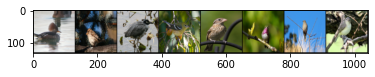

Labels:Hooded Merganser (Female/immature male), House Sparrow (Female/Juvenile), Yellow-crowned Night-Heron (Adult), Bay-breasted Warbler (Female, Nonbreeding male, Immature), Rose-breasted Grosbeak (Female/immature male), Calliope Hummingbird (Adult Male), Townsend's Solitaire, Warbling Vireo


In [10]:
dataiter = iter(data['train'])
images, labels = dataiter.next()
images = images[:8]
print(images.size())

def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print("Labels:" + ', '.join('%9s' % data['to_name'][labels[j].item()] for j in range(8)))

In [11]:
def train(net, dataloader, epochs=1, start_epoch=0, lr=0.01, momentum=0.9, decay=0.0005, 
          verbose=1, print_every=10, state=None, schedule={}, checkpoint_path=None):
    net.to(device)
    net.train()
    losses = []
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum, weight_decay=decay)

    # Load previous training state
    if state:
        net.load_state_dict(state['net'])
        optimizer.load_state_dict(state['optimizer'])
        start_epoch = state['epoch']
        losses = state['losses']

    # Fast forward lr schedule through already trained epochs
    for epoch in range(start_epoch):
        if epoch in schedule:
            print ("Learning rate: %f"% schedule[epoch])
            for g in optimizer.param_groups:
                g['lr'] = schedule[epoch]

    for epoch in range(start_epoch, epochs):
        sum_loss = 0.0

        # Update learning rate when scheduled
        if epoch in schedule:
            print ("Learning rate: %f"% schedule[epoch])
            for g in optimizer.param_groups:
                g['lr'] = schedule[epoch]

        for i, batch in enumerate(dataloader, 0):
            inputs, labels = batch[0].to(device), batch[1].to(device)

            optimizer.zero_grad()

            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()  # autograd magic, computes all the partial derivatives
            optimizer.step() # takes a step in gradient direction

            losses.append(loss.item())
            sum_loss += loss.item()

            if i % print_every == print_every-1:    # print every 10 mini-batches
                if verbose:
                  print('[%d, %5d] loss: %.3f' % (epoch, i + 1, sum_loss / print_every))
                sum_loss = 0.0
        if checkpoint_path:
            state = {'epoch': epoch+1, 'net': net.state_dict(), 'optimizer': optimizer.state_dict(), 'losses': losses}
            torch.save(state, checkpoint_path + 'checkpoint-%d.pkl'%(epoch+1))
    return losses

In [ ]:
import torch
torch.cuda.empty_cache()

In [21]:
resnet = torch.hub.load('pytorch/vision:v0.6.0', 'densenet161', pretrained=True)
resnet.fc = nn.Linear(2048, 1000) # This will reinitialize the layer as well

losses = train(resnet, data['train'], epochs=5, lr=.001, print_every=10, checkpoint_path=checkpoints)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0
Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/hub/checkpoints/densenet161-8d451a50.pth



[0,    10] loss: 10.616
[0,    20] loss: 8.289
[0,    30] loss: 7.404
[0,    40] loss: 7.157
[0,    50] loss: 6.967
[0,    60] loss: 6.894
[0,    70] loss: 6.809
[0,    80] loss: 6.744
[0,    90] loss: 6.704
[0,   100] loss: 6.656
[0,   110] loss: 6.607
[0,   120] loss: 6.540
[0,   130] loss: 6.521
[0,   140] loss: 6.483
[0,   150] loss: 6.458
[0,   160] loss: 6.382
[0,   170] loss: 6.332
[0,   180] loss: 6.320
[0,   190] loss: 6.234
[0,   200] loss: 6.213
[0,   210] loss: 6.148
[0,   220] loss: 6.185
[0,   230] loss: 6.113
[0,   240] loss: 6.052
[0,   250] loss: 5.952
[0,   260] loss: 5.908
[0,   270] loss: 5.948
[0,   280] loss: 5.799
[0,   290] loss: 5.752
[0,   300] loss: 5.746
[1,    10] loss: 5.527
[1,    20] loss: 5.470
[1,    30] loss: 5.501
[1,    40] loss: 5.418
[1,    50] loss: 5.387
[1,    60] loss: 5.271
[1,    70] loss: 5.373
[1,    80] loss: 5.222
[1,    90] loss: 5.198
[1,   100] loss: 5.150
[1,   110] loss: 5.056
[1,   120] loss: 5.072
[1,   130] loss: 4.944
[1,   140

In [ ]:
resnet = torch.hub.load('pytorch/vision:v0.6.0', 'densenet161', pretrained=True)
resnet.fc = nn.Linear(2048, 1000) # This will reinitialize the layer as well
state = torch.load(checkpoints + 'checkpoint-5.pkl')
losses = train(resnet, data['train'], epochs=7, schedule={0:.01, 4:.001}, lr=.01, print_every=10, checkpoint_path=checkpoints, state=state)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


Learning rate: 0.010000
Learning rate: 0.001000
[5,    10] loss: 1.515
[5,    20] loss: 1.510
[5,    30] loss: 1.511
[5,    40] loss: 1.425
[5,    50] loss: 1.497
[5,    60] loss: 1.419
[5,    70] loss: 1.565
[5,    80] loss: 1.459
[5,    90] loss: 1.603
[5,   100] loss: 1.511
[5,   110] loss: 1.475
[5,   120] loss: 1.469
[5,   130] loss: 1.531
[5,   140] loss: 1.457
[5,   150] loss: 1.520
[5,   160] loss: 1.461
[5,   170] loss: 1.455
[5,   180] loss: 1.502
[5,   190] loss: 1.486
[5,   200] loss: 1.510
[5,   210] loss: 1.494
[5,   220] loss: 1.398
[5,   230] loss: 1.546
[5,   240] loss: 1.436
[5,   250] loss: 1.513
[5,   260] loss: 1.488
[5,   270] loss: 1.337
[5,   280] loss: 1.451
[5,   290] loss: 1.395
[5,   300] loss: 1.505
[6,    10] loss: 1.245


In [12]:
def smooth(x, size):
  return np.convolve(x, np.ones(size)/size, mode='valid')
plt.plot(smooth(losses,50))

NameError: ignored

In [16]:
state = torch.load(checkpoints + 'checkpoint-6.pkl')
plt.plot(smooth(state['losses'], 50))


RuntimeError: ignored

In [17]:
def predict(net, dataloader, ofname):
    out = open(ofname, 'w')
    out.write("path,class\n")
    net.to(device)
    net.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for i, (images, labels) in enumerate(dataloader, 0):
            if i%100 == 0:
                print(i)
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            fname, _ = dataloader.dataset.samples[i]
            out.write("test/{},{}\n".format(fname.split('/')[-1], data['to_class'][predicted.item()]))
    out.close()

In [18]:
# Load model from checkpoint
resnet = torch.hub.load('pytorch/vision:v0.6.0', 'densenet161', pretrained=True)
resnet.fc = nn.Linear(2048, 1000) # This will reinitialize the layer as well
state = torch.load(checkpoints + 'checkpoint-6.pkl')
resnet.load_state_dict(state['net'])


predict(resnet, data['test'], checkpoints + "preds7.csv")

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0
Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/hub/checkpoints/densenet161-8d451a50.pth


RuntimeError: ignored

## Experiments On May 27th

In [ ]:
# Bigger dataset
def get_bird_data(augmentation=0):
    transform_train = transforms.Compose([
        transforms.Resize(256),
        transforms.RandomCrop(256, padding=8, padding_mode='edge'), # Take 256x256 crops from padded images
        transforms.RandomHorizontalFlip(),    # 50% of time flip image along y-axis
        transforms.ToTensor(),
    ])
    
    transform_test = transforms.Compose([
        transforms.Resize(256),
        transforms.ToTensor(),
    ])
    trainset = torchvision.datasets.ImageFolder(root='birds21wi/train', transform=transform_train)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

    testset = torchvision.datasets.ImageFolder(root='birds21wi/testing', transform=transform_test)
    testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False, num_workers=2)
    classes = open("birds21wi/names.txt").read().strip().split("\n")
    class_to_idx = trainset.class_to_idx
    idx_to_class = {int(v): int(k) for k, v in class_to_idx.items()}
    idx_to_name = {k: classes[v] for k,v in idx_to_class.items()}
    return {'train': trainloader, 'test': testloader, 'to_class': idx_to_class, 'to_name':idx_to_name}

data = get_bird_data()

In [ ]:
resnet = torch.hub.load('pytorch/vision:v0.6.0', 'resnet18', pretrained=True)
resnet.fc = nn.Linear(512, 555) # This will reinitialize the layer as well
state = torch.load(checkpoints + 'checkpoint-5.pkl')
losses = train(resnet, data['train'], epochs=10, schedule={0:.01, 8:.001}, lr=.01, print_every=10, checkpoint_path=checkpoints, state=state)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


Learning rate: 0.010000
[5,    10] loss: 2.194
[5,    20] loss: 1.788
[5,    30] loss: 1.640
[5,    40] loss: 1.571
[5,    50] loss: 1.460
[5,    60] loss: 1.403
[5,    70] loss: 1.317
[5,    80] loss: 1.382
[5,    90] loss: 1.389
[5,   100] loss: 1.285
[5,   110] loss: 1.326
[5,   120] loss: 1.280
[5,   130] loss: 1.257
[5,   140] loss: 1.260
[5,   150] loss: 1.192
[5,   160] loss: 1.254
[5,   170] loss: 1.260
[5,   180] loss: 1.234
[5,   190] loss: 1.188
[5,   200] loss: 1.124
[5,   210] loss: 1.199
[5,   220] loss: 1.186
[5,   230] loss: 1.145
[5,   240] loss: 1.160
[5,   250] loss: 1.172
[5,   260] loss: 1.153
[5,   270] loss: 1.151
[5,   280] loss: 1.152
[5,   290] loss: 1.072
[5,   300] loss: 1.111
[6,    10] loss: 0.942
[6,    20] loss: 0.958
[6,    30] loss: 0.926
[6,    40] loss: 0.988
[6,    50] loss: 0.971
[6,    60] loss: 0.935
[6,    70] loss: 0.964
[6,    80] loss: 0.978
[6,    90] loss: 0.941
[6,   100] loss: 0.947
[6,   110] loss: 0.956
[6,   120] loss: 0.893
[6,   130]

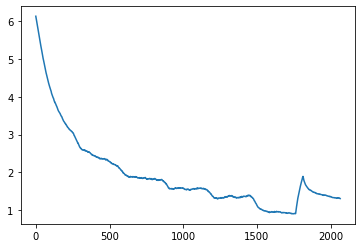

In [ ]:
state = torch.load(checkpoints + 'checkpoint-7.pkl')
plt.plot(smooth(state['losses'], 50))

In [ ]:
# Load model from checkpoint
resnet = torch.hub.load('pytorch/vision:v0.6.0', 'resnet18', pretrained=True)
resnet.fc = nn.Linear(512, 555) # This will reinitialize the layer as well
state = torch.load(checkpoints + 'checkpoint-7.pkl')
resnet.load_state_dict(state['net'])


predict(resnet, data['test'], checkpoints + "preds.csv")

NameError: ignored